In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install numpy pandas scikit-learn opencv-python matplotlib tqdm openpyxl timm grad-cam


Looking in indexes: https://download.pytorch.org/whl/cu124


In [ ]:
from google.colab import files

print("Please upload the 'anemia_dataset.zip' file. Click 'Choose Files' below:")
uploaded = files.upload()

if uploaded:
    for fn in uploaded.keys():
        print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
else:
    print("No file was uploaded.")

Please upload the 'anemia_dataset.zip' file. Click 'Choose Files' below:


Saving CP-AnemiC dataset.rar to CP-AnemiC dataset.rar
User uploaded file "CP-AnemiC dataset.rar" with length 8281392 bytes


In [ ]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
import os

RAR_FILE = "/content/CP-AnemiC dataset.rar"  # Corrected: Specify absolute path with full filename
RAW_DIR = "/content/Anemic_Project/raw"

os.makedirs(RAW_DIR, exist_ok=True)

print(f"Extracting {RAR_FILE} to {RAW_DIR}")
!unrar x -o+ "{RAR_FILE}" "{RAW_DIR}"

print(f"Extracted contents to: {RAW_DIR}")
# List contents to verify extraction
!ls -l {RAW_DIR}

Extracting /content/CP-AnemiC dataset.rar to /content/Anemic_Project/raw

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/CP-AnemiC dataset.rar

Creating    /content/Anemic_Project/raw/Anemic                        OK
Extracting  /content/Anemic_Project/raw/Anemic/Image_001.png               0%  OK 
Extracting  /content/Anemic_Project/raw/Anemic/Image_002.png               0%  OK 
Extracting  /content/Anemic_Project/raw/Anemic/Image_005.png               0%  OK 
Extracting  /content/Anemic_Project/raw/Anemic/Image_007.png               1%  OK 
Extracting  /content/Anemic_Project/raw/Anemic/Image_009.png               1%  OK 
Extracting  /content/Anemic_Project/raw/Anemic/Image_010.png               1%  OK 
Extracting  /content/Anemic_Project/raw/Anemic/Image_013.png               1%  OK 
Extracting  /content/Anemic_Project/raw/Anemic/Image_015.png               1%

In [ ]:
import os, glob
import pandas as pd

RAW_DIR = "/content/Anemic_Project/raw"

rows = []

# label = 1 → anemic
for path in glob.glob(f"{RAW_DIR}/Anemic/*"):
    if os.path.isfile(path):
        rows.append({"image_path": path, "label": 1})

# label = 0 → non-anemic (corrected directory name to 'Non-anemic')
for path in glob.glob(f"{RAW_DIR}/Non-anemic/*"):
    if os.path.isfile(path):
        rows.append({"image_path": path, "label": 0})

df = pd.DataFrame(rows)
print(df["label"].value_counts())
df.head()

label
1    424
0    286
Name: count, dtype: int64


,image_path,label
0,/content/Anemic_Project/raw/Anemic/Image_155.png,1
1,/content/Anemic_Project/raw/Anemic/Image_443.png,1
2,/content/Anemic_Project/raw/Anemic/Image_336.png,1
3,/content/Anemic_Project/raw/Anemic/Image_018.png,1
4,/content/Anemic_Project/raw/Anemic/Image_029.png,1


In [ ]:
import os
from sklearn.model_selection import train_test_split

BASE_DIR = "/content/Anemic_Project"
PROC_DIR = os.path.join(BASE_DIR, "processed")
os.makedirs(PROC_DIR, exist_ok=True)

train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

train_path = f"{PROC_DIR}/train.csv"
val_path   = f"{PROC_DIR}/val.csv"

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)

print("Train size:", len(train_df))
print("Val size:", len(val_df))

Train size: 568
Val size: 142


In [ ]:
import os, glob
import pandas as pd

RAW_DIR = "/content/Anemic_Project/raw"

rows = []

# label = 1 → anemic
for path in glob.glob(f"{RAW_DIR}/Anemic/*"):
    if os.path.isfile(path):
        rows.append({"image_path": path, "label": 1})

# label = 0 → non-anemic (THIS IS THE CORRECT FOLDER NAME NOW)
for path in glob.glob(f"{RAW_DIR}/Non-anemic/*"):
    if os.path.isfile(path):
        rows.append({"image_path": path, "label": 0})

df = pd.DataFrame(rows)
print(df["label"].value_counts())
df.head()


label
1    424
0    286
Name: count, dtype: int64


,image_path,label
0,/content/Anemic_Project/raw/Anemic/Image_155.png,1
1,/content/Anemic_Project/raw/Anemic/Image_443.png,1
2,/content/Anemic_Project/raw/Anemic/Image_336.png,1
3,/content/Anemic_Project/raw/Anemic/Image_018.png,1
4,/content/Anemic_Project/raw/Anemic/Image_029.png,1


In [ ]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as T

def get_transforms(train=True):
    if train:
        return T.Compose([
            T.ToImage(),
            T.Resize((300, 300)),
            T.RandomHorizontalFlip(),
            T.ColorJitter(brightness=0.2, contrast=0.2),
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])
    else:
        return T.Compose([
            T.ToImage(),
            T.Resize((300, 300)),
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])

class AnemiaDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(row["label"], dtype=torch.long)
        return img, label


In [ ]:
import os
import pandas as pd
from torch.utils.data import DataLoader

BASE_DIR = "/content/Anemic_Project"
PROC_DIR = os.path.join(BASE_DIR, "processed")

train_csv = os.path.join(PROC_DIR, "train.csv")
val_csv   = os.path.join(PROC_DIR, "val.csv")

print("Train CSV:", train_csv)
print("Val   CSV:", val_csv)

train_ds = AnemiaDataset(train_csv, transform=get_transforms(train=True))
val_ds   = AnemiaDataset(val_csv,   transform=get_transforms(train=False))

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=2)

print("Train size:", len(train_ds))
print("Val size:", len(val_ds))


Train CSV: /content/Anemic_Project/processed/train.csv
Val   CSV: /content/Anemic_Project/processed/val.csv
Train size: 568
Val size: 142


In [ ]:
!pip install timm


In [ ]:
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch

class SimpleClassifier(nn.Module):
    def __init__(self, backbone_name="efficientnet_b0", dropout_p=0.3):
        super().__init__()
        self.backbone = timm.create_model(
            backbone_name, pretrained=True, num_classes=0, global_pool="avg"
        )
        in_features = self.backbone.num_features
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(in_features, 1)   # binary output

    def forward(self, x):
        feats = self.backbone(x)
        feats = self.dropout(feats)
        logit = self.fc(feats).squeeze(1)     # shape (N,)
        return logit


In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = SimpleClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

EPOCHS = 10

# lists for accuracy tracking
train_acc_list = []
val_acc_list   = []

for epoch in range(1, EPOCHS + 1):

    # ---- TRAIN ----
    model.train()
    train_losses = []
    train_true = []
    train_pred = []

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        imgs = imgs.to(device)
        labels = labels.float().to(device)

        logits = model(imgs)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # ---- TRAIN ACCURACY ----
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long().cpu().numpy()
        train_pred.extend(preds)
        train_true.extend(labels.cpu().numpy())

    train_true = np.array(train_true)
    train_pred = np.array(train_pred)
    train_acc = (train_pred == train_true).mean()
    train_acc_list.append(train_acc)

    # ---- VALIDATE ----
    model.eval()
    val_losses = []
    y_true, y_prob = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.float().to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)
            val_losses.append(loss.item())

            probs = torch.sigmoid(logits)
            y_true.extend(labels.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = (y_prob >= 0.5).astype(int)

    # ---- VAL ACCURACY ----
    val_acc = (y_pred == y_true).mean()
    val_acc_list.append(val_acc)

    auc = roc_auc_score(y_true, y_prob)
    f1  = f1_score(y_true, y_pred)

    print(
        f"Epoch {epoch}: "
        f"Train loss {np.mean(train_losses):.4f} | "
        f"Val loss {np.mean(val_losses):.4f} | "
        f"AUC {auc:.3f} | F1 {f1:.3f} | "
        f"Train Acc {train_acc:.3f} | Val Acc {val_acc:.3f}"
    )

    # ---- SAVE MODEL ----
    save_path = "/content/Anemic_Project/best_classifier.pt"
    torch.save(model.state_dict(), save_path)
    print(f">> Saved model at epoch {epoch}")


Device: cuda


Epoch 1: 100%|██████████| 36/36 [00:08<00:00,  4.44it/s]


Epoch 1: Train loss 0.6680 | Val loss 0.6004 | AUC 0.797 | F1 0.821 | Train Acc 0.570 | Val Acc 0.754
>> Saved model at epoch 1


Epoch 2: 100%|██████████| 36/36 [00:06<00:00,  5.67it/s]


Epoch 2: Train loss 0.5503 | Val loss 0.4678 | AUC 0.905 | F1 0.856 | Train Acc 0.736 | Val Acc 0.810
>> Saved model at epoch 2


Epoch 3: 100%|██████████| 36/36 [00:06<00:00,  5.91it/s]


Epoch 3: Train loss 0.4675 | Val loss 0.4055 | AUC 0.910 | F1 0.862 | Train Acc 0.812 | Val Acc 0.831
>> Saved model at epoch 3


Epoch 4: 100%|██████████| 36/36 [00:05<00:00,  6.33it/s]


Epoch 4: Train loss 0.3747 | Val loss 0.3742 | AUC 0.924 | F1 0.857 | Train Acc 0.863 | Val Acc 0.810
>> Saved model at epoch 4


Epoch 5: 100%|██████████| 36/36 [00:06<00:00,  5.97it/s]


Epoch 5: Train loss 0.3050 | Val loss 0.3930 | AUC 0.900 | F1 0.851 | Train Acc 0.882 | Val Acc 0.817
>> Saved model at epoch 5


Epoch 6: 100%|██████████| 36/36 [00:05<00:00,  6.30it/s]


Epoch 6: Train loss 0.2376 | Val loss 0.3531 | AUC 0.914 | F1 0.833 | Train Acc 0.903 | Val Acc 0.803
>> Saved model at epoch 6


Epoch 7: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]


Epoch 7: Train loss 0.2055 | Val loss 0.3932 | AUC 0.910 | F1 0.835 | Train Acc 0.935 | Val Acc 0.817
>> Saved model at epoch 7


Epoch 8: 100%|██████████| 36/36 [00:05<00:00,  6.37it/s]


Epoch 8: Train loss 0.1531 | Val loss 0.4378 | AUC 0.917 | F1 0.856 | Train Acc 0.945 | Val Acc 0.817
>> Saved model at epoch 8


Epoch 9: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]


Epoch 9: Train loss 0.1255 | Val loss 0.4116 | AUC 0.905 | F1 0.836 | Train Acc 0.956 | Val Acc 0.810
>> Saved model at epoch 9


Epoch 10: 100%|██████████| 36/36 [00:05<00:00,  6.31it/s]


Epoch 10: Train loss 0.1506 | Val loss 0.3788 | AUC 0.927 | F1 0.867 | Train Acc 0.937 | Val Acc 0.831
>> Saved model at epoch 10


In [ ]:
# Check train labels distribution
all_train_labels = []
for _, labels in train_loader:
    all_train_labels.extend(labels.numpy())

all_train_labels = np.array(all_train_labels)
print("Train label counts:",
      "class 0 =", np.sum(all_train_labels == 0),
      "| class 1 =", np.sum(all_train_labels == 1))

# Check val labels distribution
all_val_labels = []
for _, labels in val_loader:
    all_val_labels.extend(labels.numpy())

all_val_labels = np.array(all_val_labels)
print("Val label counts:",
      "class 0 =", np.sum(all_val_labels == 0),
      "| class 1 =", np.sum(all_val_labels == 1))


Train label counts: class 0 = 229 | class 1 = 339
Val label counts: class 0 = 57 | class 1 = 85


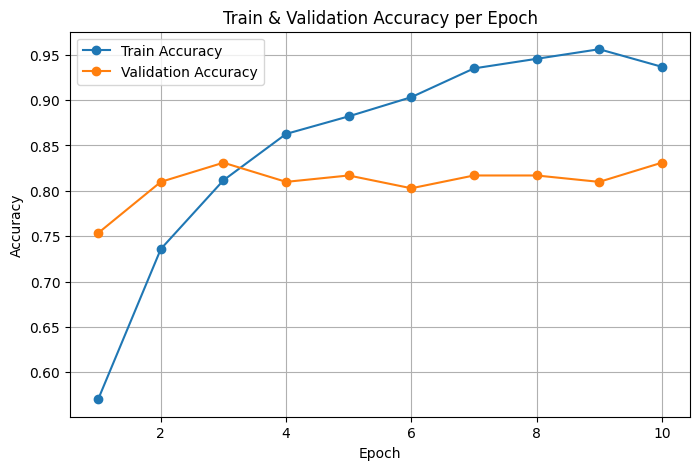

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_acc_list) + 1))

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc_list, marker='o', label="Train Accuracy")
plt.plot(epochs, val_acc_list, marker='o', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy per Epoch")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
!ls -l /content/Anemic_Project


total 15968
-rw-r--r-- 1 root root 16339103 Nov 22 04:47 best_classifier.pt
drwxr-xr-x 2 root root     4096 Nov 22 04:31 processed
drwxr-xr-x 4 root root     4096 Nov 22 04:28 raw


In [ ]:
import pandas as pd

train_path = "/content/Anemic_Project/processed/train.csv"
val_path   = "/content/Anemic_Project/processed/val.csv"

df_train = pd.read_csv(train_path)
df_val   = pd.read_csv(val_path)

print("Train:", df_train.shape)
print("Val:", df_val.shape)

df_train.head()


Train: (568, 2)
Val: (142, 2)


,image_path,label
0,/content/Anemic_Project/raw/Anemic/Image_285.png,1
1,/content/Anemic_Project/raw/Non-anemic/Image_0...,0
2,/content/Anemic_Project/raw/Non-anemic/Image_4...,0
3,/content/Anemic_Project/raw/Anemic/Image_330.png,1
4,/content/Anemic_Project/raw/Anemic/Image_126.png,1


Testing on: /content/Anemic_Project/raw/Anemic/Image_330.png


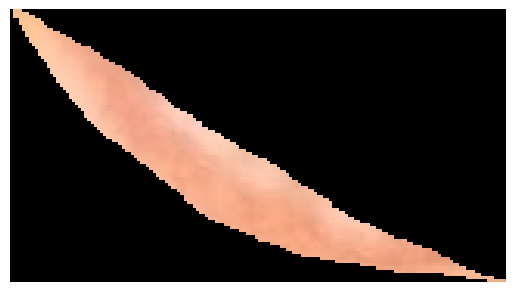

Prob Anemic = 0.994
→ Predicted: ANEMIC


In [ ]:
import matplotlib.pyplot as plt

# reload best model
model = SimpleClassifier().to(device)
model.load_state_dict(torch.load("/content/Anemic_Project/best_classifier.pt", map_location=device))
model.eval()

def predict_one(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    tf = get_transforms(train=False)
    x = tf(img_rgb).unsqueeze(0).to(device)

    with torch.no_grad():
        logit = model(x)
        prob_anemic = torch.sigmoid(logit)[0].item()

    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()
    print(f"Prob Anemic = {prob_anemic:.3f}")
    if prob_anemic >= 0.5:
        print("→ Predicted: ANEMIC")
    else:
        print("→ Predicted: NON-ANEMIC")

# use a real path from your CSV
sample_path = pd.read_csv(train_csv).iloc[3]["image_path"]
print("Testing on:", sample_path)
predict_one(sample_path)


Anemic sample: /content/Anemic_Project/raw/Anemic/Image_285.png


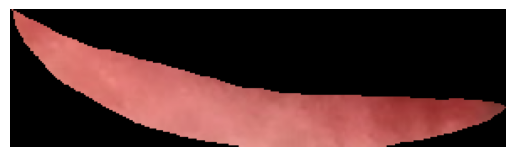

Prob Anemic = 0.984
→ Predicted: ANEMIC
Non-anemic sample: /content/Anemic_Project/raw/Non-anemic/Image_059.png


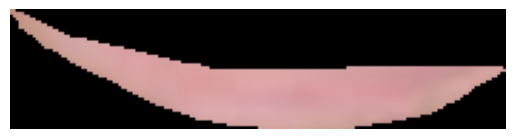

Prob Anemic = 0.011
→ Predicted: NON-ANEMIC


In [ ]:
df_train = pd.read_csv(train_csv)

# one anemic example
pos_path = df_train[df_train["label"] == 1].iloc[0]["image_path"]
print("Anemic sample:", pos_path)
predict_one(pos_path)

# one non-anemic example
neg_path = df_train[df_train["label"] == 0].iloc[0]["image_path"]
print("Non-anemic sample:", neg_path)
predict_one(neg_path)


In [ ]:
torch.save(model.state_dict(), "/content/Anemic_Project/simple_classifier_final.pt")


In [ ]:
import pandas as pd
import os

BASE_DIR = "/content/Anemic_Project"
RAW_DIR  = f"{BASE_DIR}/raw"
PROC_DIR = f"{BASE_DIR}/processed"

train_csv = f"{PROC_DIR}/train.csv"
val_csv   = f"{PROC_DIR}/val.csv"

train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)

excel_path = f"{RAW_DIR}/Anemia_Data_Collection_Sheet.xlsx"
meta = pd.read_excel("/content/Anemic_Project/raw/Anemia_Data_Collection_Sheet.xlsx")
meta.columns = [c.strip() for c in meta.columns]   # clean names
meta.head()


,IMAGE_ID,HB_LEVEL,Severity,Age(Months),GENDER,REMARK,HOSPITAL,CITY/TOWN,MUNICIPALITY/DISTRICT,REGION,COUNTRY
0,Image_001,9.8,Moderate,6,Female,Anemic,Nkawie-Toase Government Hospital,Nkawie-Toase,Atwima Nwabiagya South,Ashanti,Ghana
1,Image_002,9.9,Moderate,24,Male,Anemic,Ejusu Government Hospital,Ejusu,Ejusu Municipality,Ashanti,Ghana
2,Image_003,11.1,Non-Anemic,24,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana
3,Image_004,12.5,Non-Anemic,12,Male,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana
4,Image_005,9.9,Moderate,24,Male,Anemic,Sunyani Municipal Hospital,Sunyani,Sunyani Municipality,Bono,Ghana


In [ ]:
import os

# add file_stem to excel
meta["file_stem"] = meta["IMAGE_ID"].astype(str)

def extract_stem(path):
    fname = os.path.basename(path)      # Image_084.png
    stem = os.path.splitext(fname)[0]   # Image_084
    return stem

for df in [train_df, val_df]:
    df["file_stem"] = df["image_path"].apply(extract_stem)

# keep only the columns we need from Excel
meta_slim = meta[["file_stem", "HB_LEVEL"]]

# merge Hb
train_hb = train_df.merge(meta_slim, on="file_stem", how="left")
val_hb   = val_df.merge(meta_slim, on="file_stem", how="left")

print(train_hb[["image_path", "label", "HB_LEVEL"]].head())
print(train_hb["HB_LEVEL"].isna().sum(), "rows without Hb in train")
print(val_hb["HB_LEVEL"].isna().sum(), "rows without Hb in val")


                                          image_path  label  HB_LEVEL
0   /content/Anemic_Project/raw/Anemic/Image_285.png      1       5.2
1  /content/Anemic_Project/raw/Non-anemic/Image_0...      0      11.9
2  /content/Anemic_Project/raw/Non-anemic/Image_4...      0      11.7
3   /content/Anemic_Project/raw/Anemic/Image_330.png      1      10.5
4   /content/Anemic_Project/raw/Anemic/Image_126.png      1       8.5
0 rows without Hb in train
0 rows without Hb in val


In [ ]:
train_hb = train_hb.dropna(subset=["HB_LEVEL"]).reset_index(drop=True)
val_hb   = val_hb.dropna(subset=["HB_LEVEL"]).reset_index(drop=True)

train_hb.to_csv(f"{PROC_DIR}/train_hb.csv", index=False)
val_hb.to_csv(f"{PROC_DIR}/val_hb.csv", index=False)

print("Train with Hb:", train_hb.shape)
print("Val with Hb:", val_hb.shape)


Train with Hb: (568, 4)
Val with Hb: (142, 4)


In [ ]:
class AnemiaMultiTaskDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform

        # ensure no missing Hb
        self.df = self.df.dropna(subset=["HB_LEVEL"]).reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        y_class = torch.tensor(row["label"], dtype=torch.long)
        y_hb    = torch.tensor(row["HB_LEVEL"], dtype=torch.float32)

        return img, (y_class, y_hb)


In [ ]:
train_ds_mt = AnemiaMultiTaskDataset(f"{PROC_DIR}/train_hb.csv",
                                     transform=get_transforms(train=True))
val_ds_mt   = AnemiaMultiTaskDataset(f"{PROC_DIR}/val_hb.csv",
                                     transform=get_transforms(train=False))

train_loader_mt = DataLoader(train_ds_mt, batch_size=16, shuffle=True,  num_workers=2)
val_loader_mt   = DataLoader(val_ds_mt,   batch_size=16, shuffle=False, num_workers=2)

len(train_ds_mt), len(val_ds_mt)


(568, 142)

In [ ]:
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch

class AnemiaMultiTask(nn.Module):
    def __init__(self, backbone_name="efficientnet_b0", dropout_p=0.3):
        super().__init__()
        self.backbone = timm.create_model(
            backbone_name, pretrained=True, num_classes=0, global_pool="avg"
        )
        in_features = self.backbone.num_features
        self.dropout = nn.Dropout(dropout_p)

        # HEAD 1 – Classification (anemic / non-anemic)
        self.cls_head = nn.Linear(in_features, 1)

        # HEAD 2 – Regression (Hb level)
        self.hb_head  = nn.Linear(in_features, 1)

    def forward(self, x):
        feats = self.backbone(x)
        feats = self.dropout(feats)

        cls_logit = self.cls_head(feats).squeeze(1)
        hb_pred   = self.hb_head(feats).squeeze(1)
        return cls_logit, hb_pred


def multitask_loss(logits, hb_pred, y_class, y_hb,
                   alpha_cls=1.0, alpha_reg=0.5):
    bce = F.binary_cross_entropy_with_logits(logits, y_class.float())
    mse = F.mse_loss(hb_pred, y_hb)
    return alpha_cls * bce + alpha_reg * mse, bce, mse


In [ ]:
model_mt = AnemiaMultiTask().to(device)


In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model_mt = AnemiaMultiTask().to(device)

# optimizer for model training (NOT temperature scaling)
opt_model = torch.optim.AdamW(model_mt.parameters(), lr=1e-4, weight_decay=1e-4)

EPOCHS = 10

train_acc_list = []
val_acc_list   = []
train_loss_list = []
val_loss_list   = []

for epoch in range(1, EPOCHS + 1):

    # ------------------ TRAIN ------------------
    model_mt.train()
    train_losses = []
    correct = 0
    total = 0

    for imgs, (y_class, y_hb) in tqdm(train_loader_mt, desc=f"Epoch {epoch}"):
        imgs, y_class, y_hb = imgs.to(device), y_class.to(device), y_hb.to(device)

        opt_model.zero_grad()

        logits, hb_pred = model_mt(imgs)

        # multi-task loss
        bce = F.binary_cross_entropy_with_logits(logits, y_class.float())
        mse = F.mse_loss(hb_pred, y_hb)
        loss = bce + 0.5 * mse

        loss.backward()
        opt_model.step()

        train_losses.append(loss.item())

        # ---- Train accuracy (classification only) ----
        preds = (torch.sigmoid(logits) >= 0.5).long()
        correct += (preds == y_class).sum().item()
        total += y_class.size(0)

    train_acc = correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(np.mean(train_losses))

    # ------------------ VALIDATION ------------------
    model_mt.eval()
    val_losses = []
    correct = 0
    total = 0

    all_y_true = []
    all_y_prob = []
    all_hb_true = []
    all_hb_pred = []

    with torch.no_grad():
        for imgs, (y_class, y_hb) in val_loader_mt:
            imgs, y_class, y_hb = imgs.to(device), y_class.to(device), y_hb.to(device)

            logits, hb_pred = model_mt(imgs)

            bce = F.binary_cross_entropy_with_logits(logits, y_class.float())
            mse = F.mse_loss(hb_pred, y_hb)
            loss = bce + 0.5 * mse

            val_losses.append(loss.item())

            # accuracy
            preds = (torch.sigmoid(logits) >= 0.5).long()
            correct += (preds == y_class).sum().item()
            total += y_class.size(0)

            # for AUC, MAE, etc.
            probs = torch.sigmoid(logits)
            all_y_true.extend(y_class.cpu().numpy())
            all_y_prob.extend(probs.cpu().numpy())
            all_hb_true.extend(y_hb.cpu().numpy())
            all_hb_pred.extend(hb_pred.cpu().numpy())

    val_acc = correct / total
    val_acc_list.append(val_acc)
    val_loss_list.append(np.mean(val_losses))

    # --- extra metrics ---
    all_y_true = np.array(all_y_true)
    all_y_prob = np.array(all_y_prob)
    y_pred = (all_y_prob >= 0.5).astype(int)

    auc = roc_auc_score(all_y_true, all_y_prob)
    f1 = f1_score(all_y_true, y_pred)
    hb_mae = np.mean(np.abs(np.array(all_hb_true) - np.array(all_hb_pred)))

    print(f"Epoch {epoch}: "
          f"Train Acc {train_acc:.3f} | Val Acc {val_acc:.3f} | "
          f"Train Loss {np.mean(train_losses):.3f} | Val Loss {np.mean(val_losses):.3f} | "
          f"AUC {auc:.3f} | F1 {f1:.3f} | Hb MAE {hb_mae:.2f}")

# SAVE MODEL
torch.save(model_mt.state_dict(), "/content/Anemic_Project/multitask_model.pt")
print("\nSaved retrained model.")


Device: cuda


Epoch 1: 100%|██████████| 36/36 [00:06<00:00,  5.74it/s]


Epoch 1: Train Acc 0.530 | Val Acc 0.648 | Train Loss 44.436 | Val Loss 21.423 | AUC 0.695 | F1 0.762 | Hb MAE 6.03


Epoch 2: 100%|██████████| 36/36 [00:05<00:00,  6.20it/s]


Epoch 2: Train Acc 0.583 | Val Acc 0.606 | Train Loss 19.447 | Val Loss 6.309 | AUC 0.514 | F1 0.752 | Hb MAE 2.90


Epoch 3: 100%|██████████| 36/36 [00:06<00:00,  5.85it/s]


Epoch 3: Train Acc 0.595 | Val Acc 0.599 | Train Loss 7.896 | Val Loss 4.959 | AUC 0.611 | F1 0.749 | Hb MAE 2.52


Epoch 4: 100%|██████████| 36/36 [00:05<00:00,  6.27it/s]


Epoch 4: Train Acc 0.625 | Val Acc 0.634 | Train Loss 3.949 | Val Loss 3.729 | AUC 0.743 | F1 0.755 | Hb MAE 2.06


Epoch 5: 100%|██████████| 36/36 [00:05<00:00,  6.04it/s]


Epoch 5: Train Acc 0.683 | Val Acc 0.711 | Train Loss 2.537 | Val Loss 3.050 | AUC 0.792 | F1 0.796 | Hb MAE 1.77


Epoch 6: 100%|██████████| 36/36 [00:05<00:00,  6.35it/s]


Epoch 6: Train Acc 0.690 | Val Acc 0.718 | Train Loss 2.351 | Val Loss 2.968 | AUC 0.819 | F1 0.792 | Hb MAE 1.72


Epoch 7: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]


Epoch 7: Train Acc 0.717 | Val Acc 0.732 | Train Loss 1.867 | Val Loss 2.851 | AUC 0.853 | F1 0.812 | Hb MAE 1.74


Epoch 8: 100%|██████████| 36/36 [00:06<00:00,  5.47it/s]


Epoch 8: Train Acc 0.787 | Val Acc 0.782 | Train Loss 1.708 | Val Loss 3.099 | AUC 0.867 | F1 0.825 | Hb MAE 1.71


Epoch 9: 100%|██████████| 36/36 [00:05<00:00,  6.01it/s]


Epoch 9: Train Acc 0.812 | Val Acc 0.746 | Train Loss 1.668 | Val Loss 2.870 | AUC 0.856 | F1 0.811 | Hb MAE 1.64


Epoch 10: 100%|██████████| 36/36 [00:05<00:00,  6.43it/s]


Epoch 10: Train Acc 0.815 | Val Acc 0.761 | Train Loss 1.581 | Val Loss 2.969 | AUC 0.879 | F1 0.819 | Hb MAE 1.72

Saved retrained model.


Testing on: /content/Anemic_Project/raw/Anemic/Image_285.png


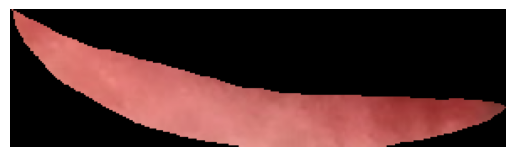

Prob Anemic = 0.826
Predicted Hb = 4.38 g/dL
→ Predicted: ANEMIC


In [ ]:
# reload multi-task model
mt_model = AnemiaMultiTask().to(device)
mt_model.load_state_dict(torch.load("/content/Anemic_Project/multitask_model.pt", map_location=device))
mt_model.eval()

def predict_one_mt(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    tf = get_transforms(train=False)
    x = tf(img_rgb).unsqueeze(0).to(device)

    with torch.no_grad():
        logit, hb_pred = mt_model(x)
        prob_anemic = torch.sigmoid(logit)[0].item()
        hb_val = hb_pred[0].item()

    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()
    print(f"Prob Anemic = {prob_anemic:.3f}")
    print(f"Predicted Hb = {hb_val:.2f} g/dL")
    if prob_anemic >= 0.5:
        print("→ Predicted: ANEMIC")
    else:
        print("→ Predicted: NON-ANEMIC")

sample_path = train_hb.iloc[0]["image_path"]
print("Testing on:", sample_path)
predict_one_mt(sample_path)


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score

model_mt.eval()

all_y_true = []
all_y_prob = []
all_hb_true = []
all_hb_pred = []

with torch.no_grad():
    for imgs, (y_class, y_hb) in val_loader_mt:
        imgs = imgs.to(device)
        y_class = y_class.to(device)
        y_hb = y_hb.to(device)

        logits, hb_pred = model_mt(imgs)
        probs = torch.sigmoid(logits)

        all_y_true.extend(y_class.cpu().numpy())
        all_y_prob.extend(probs.cpu().numpy())
        all_hb_true.extend(y_hb.cpu().numpy())
        all_hb_pred.extend(hb_pred.cpu().numpy())

all_y_true = np.array(all_y_true)
all_y_prob = np.array(all_y_prob)
all_hb_true = np.array(all_hb_true)
all_hb_pred = np.array(all_hb_pred)

y_pred = (all_y_prob >= 0.5).astype(int)

auc = roc_auc_score(all_y_true, all_y_prob)
f1  = f1_score(all_y_true, y_pred)
hb_mae = np.mean(np.abs(all_hb_true - all_hb_pred))

print(f"AUC        : {auc:.3f}")
print(f"F1         : {f1:.3f}")
print(f"Hb MAE     : {hb_mae:.2f} g/dL")


AUC        : 0.879
F1         : 0.819
Hb MAE     : 1.72 g/dL


In [ ]:
@torch.no_grad()
def mc_predict_batch(model, imgs, T=20):
    """
    imgs: batch tensor on device
    T: number of MC samples
    returns: prob_mean, prob_std, hb_mean, hb_std (numpy arrays)
    """
    model.train()  # IMPORTANT: keep dropout ON

    probs_list = []
    hb_list = []

    for _ in range(T):
        logits, hb_pred = model(imgs)
        probs = torch.sigmoid(logits)
        probs_list.append(probs.cpu().numpy())
        hb_list.append(hb_pred.cpu().numpy())

    probs_arr = np.stack(probs_list, axis=0)  # (T, N)
    hb_arr = np.stack(hb_list, axis=0)        # (T, N)

    prob_mean = probs_arr.mean(axis=0)
    prob_std  = probs_arr.std(axis=0)
    hb_mean   = hb_arr.mean(axis=0)
    hb_std    = hb_arr.std(axis=0)

    return prob_mean, prob_std, hb_mean, hb_std


In [ ]:
# take one batch from val_loader_mt
imgs, (y_class, y_hb) = next(iter(val_loader_mt))
imgs = imgs.to(device)

prob_mean, prob_std, hb_mean, hb_std = mc_predict_batch(model_mt, imgs, T=20)

for i in range(min(5, len(prob_mean))):
    print(f"Sample {i}:")
    print(f"  True label   : {y_class[i].item()}  (1=anemic, 0=non)")
    print(f"  Prob anemic  : {prob_mean[i]:.3f}")
    print(f"  Uncertainty  : {prob_std[i]:.3f}")
    print(f"  True Hb      : {y_hb[i].item():.2f}")
    print(f"  Pred Hb mean : {hb_mean[i]:.2f}")
    print(f"  Hb uncert    : {hb_std[i]:.3f}")
    print()


Sample 0:
  True label   : 0  (1=anemic, 0=non)
  Prob anemic  : 0.288
  Uncertainty  : 0.041
  True Hb      : 14.70
  Pred Hb mean : 14.08
  Hb uncert    : 0.335

Sample 1:
  True label   : 0  (1=anemic, 0=non)
  Prob anemic  : 0.582
  Uncertainty  : 0.034
  True Hb      : 12.90
  Pred Hb mean : 9.96
  Hb uncert    : 0.167

Sample 2:
  True label   : 0  (1=anemic, 0=non)
  Prob anemic  : 0.533
  Uncertainty  : 0.029
  True Hb      : 12.00
  Pred Hb mean : 11.47
  Hb uncert    : 0.293

Sample 3:
  True label   : 1  (1=anemic, 0=non)
  Prob anemic  : 0.735
  Uncertainty  : 0.025
  True Hb      : 10.70
  Pred Hb mean : 8.26
  Hb uncert    : 0.258

Sample 4:
  True label   : 0  (1=anemic, 0=non)
  Prob anemic  : 0.432
  Uncertainty  : 0.032
  True Hb      : 11.60
  Pred Hb mean : 9.84
  Hb uncert    : 0.245



In [ ]:
def selective_prediction(prob_mean, prob_std,
                         conf_thresh=0.75,
                         unc_thresh=0.08):
    """
    Returns:
        1  = confident anemic
        0  = confident non-anemic
        -1 = uncertain → refer to clinician
    """
    decisions = []
    for p, u in zip(prob_mean, prob_std):
        if u > unc_thresh:
            decisions.append(-1)  # too uncertain, refer
        else:
            if p >= conf_thresh:
                decisions.append(1)   # anemic
            elif p <= 1 - conf_thresh:
                decisions.append(0)   # non-anemic
            else:
                decisions.append(-1)  # borderline, refer
    return np.array(decisions)


In [ ]:
decisions = selective_prediction(prob_mean, prob_std)
print("Decisions for first batch:", decisions[:10])
print("Counts:",
      "anemic:", np.sum(decisions == 1),
      "non-anemic:", np.sum(decisions == 0),
      "refer:", np.sum(decisions == -1))


Decisions for first batch: [-1 -1 -1 -1 -1 -1 -1 -1  0 -1]
Counts: anemic: 0 non-anemic: 1 refer: 15


In [ ]:
all_y_true = []
all_prob_mean = []
all_prob_std = []

model_mt.eval()  # we’ll switch it to train() inside mc_predict_batch

for imgs, (y_class, _) in val_loader_mt:
    imgs = imgs.to(device)
    y_class = y_class.numpy()  # keep on CPU as numpy

    prob_mean, prob_std, _, _ = mc_predict_batch(model_mt, imgs, T=20)

    all_y_true.extend(list(y_class))
    all_prob_mean.extend(list(prob_mean))
    all_prob_std.extend(list(prob_std))

all_y_true = np.array(all_y_true)
all_prob_mean = np.array(all_prob_mean)
all_prob_std = np.array(all_prob_std)


In [ ]:
decisions = selective_prediction(all_prob_mean, all_prob_std,
                                 conf_thresh=0.75,
                                 unc_thresh=0.08)

mask_auto = decisions != -1
mask_anemic = decisions == 1
mask_non   = decisions == 0

print("Total samples       :", len(all_y_true))
print("Auto-classified     :", mask_auto.sum())
print("Referred (uncertain):", (decisions == -1).sum())


Total samples       : 142
Auto-classified     : 15
Referred (uncertain): 127


In [ ]:
from sklearn.metrics import accuracy_score

auto_true = all_y_true[mask_auto]
auto_pred = decisions[mask_auto]   # 0 or 1

if len(auto_true) > 0:
    acc_auto = accuracy_score(auto_true, auto_pred)
    print(f"Accuracy on auto-classified subset: {acc_auto:.3f}")
else:
    print("No auto-classified samples with these thresholds.")


Accuracy on auto-classified subset: 1.000


In [ ]:
!pip install grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np


In [ ]:
target_layer = model_mt.backbone.conv_head  # last conv layer


In [ ]:
import torch.nn as nn
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

# Wrapper: use only classification output for Grad-CAM
class ClassifierWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        cls_logit, hb_pred = self.model(x)  # your multi-task outputs
        return cls_logit.unsqueeze(1)       # shape [N, 1] for Grad-CAM


In [ ]:
wrapped_model = ClassifierWrapper(model_mt).to(device)
target_layer = wrapped_model.model.backbone.conv_head  # last conv layer of EfficientNet


In [ ]:
def gradcam_visualize(img_path):
    wrapped_model.eval()

    # 1. Load image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2. Resize ORIGINAL image to model input size (300×300)
    img_resized = cv2.resize(img_rgb, (300, 300))

    # 3. Transform to tensor
    tf = get_transforms(train=False)
    input_tensor = tf(img_rgb).unsqueeze(0).to(device)   # original gets resized by transform

    # 4. GradCAM object
    cam = GradCAM(model=wrapped_model, target_layers=[target_layer])

    # 5. Compute CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]   # shape (H,W)

    # 6. Overlay
    img_norm = img_resized.astype(np.float32) / 255.0
    visualization = show_cam_on_image(img_norm, grayscale_cam, use_rgb=True)

    # 7. Show result
    plt.figure(figsize=(6, 6))
    plt.imshow(visualization)
    plt.axis("off")
    plt.show()


Grad-CAM for: /content/Anemic_Project/raw/Anemic/Image_285.png


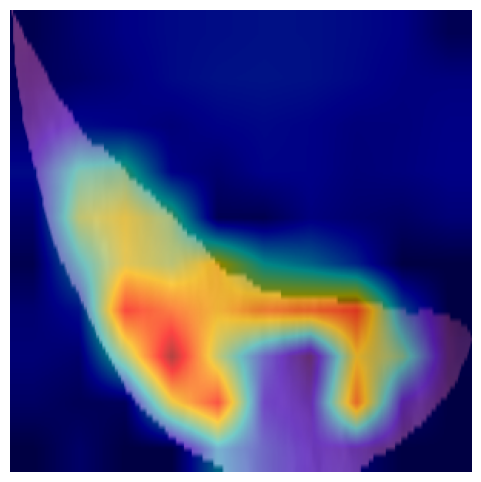

Grad-CAM (non-anemic) for: /content/Anemic_Project/raw/Non-anemic/Image_059.png


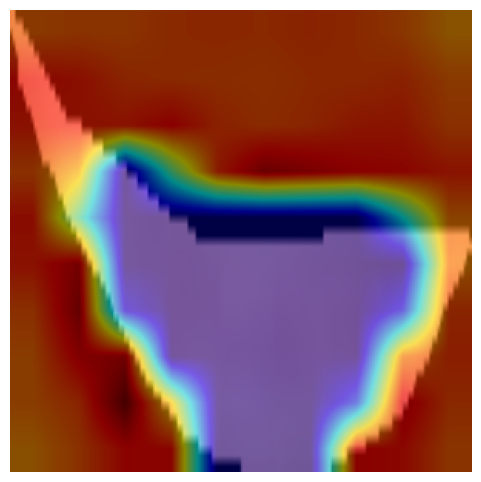

In [ ]:
# Anemic example
sample_img = train_hb.iloc[0]["image_path"]
print("Grad-CAM for:", sample_img)
gradcam_visualize(sample_img)

# Non-anemic example
neg_sample = train_hb[train_hb["label"] == 0].iloc[0]["image_path"]
print("Grad-CAM (non-anemic) for:", neg_sample)
gradcam_visualize(neg_sample)


In [ ]:
import torch
import numpy as np

model_mt.eval()   # deterministic (dropout OFF)

all_logits = []
all_labels = []

with torch.no_grad():
    for imgs, (y_class, _) in val_loader_mt:
        imgs = imgs.to(device)
        y_class = y_class.to(device)

        logits, _ = model_mt(imgs)         # only classification head
        all_logits.append(logits.detach())
        all_labels.append(y_class.detach())

all_logits = torch.cat(all_logits).to(device)   # shape [N]
all_labels = torch.cat(all_labels).float().to(device)  # shape [N]

print("Val samples:", all_logits.shape[0])


Val samples: 142


In [ ]:
import matplotlib.pyplot as plt

def compute_ece(probs, labels, n_bins=10):
    """
    probs, labels: numpy arrays of shape [N]
    """
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    indices = np.digitize(probs, bins) - 1   # bin index 0..n_bins-1

    ece = 0.0
    for b in range(n_bins):
        mask = indices == b
        if np.sum(mask) == 0:
            continue
        bin_probs = probs[mask]
        bin_labels = labels[mask]
        avg_conf = bin_probs.mean()
        avg_acc  = (bin_labels == (bin_probs >= 0.5)).mean()
        ece += (np.sum(mask) / len(probs)) * abs(avg_conf - avg_acc)
    return ece


def reliability_plot(probs, labels, n_bins=10, title="Reliability diagram"):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    indices = np.digitize(probs, bins) - 1

    bin_acc = []
    bin_conf = []
    bin_centers = []

    for b in range(n_bins):
        mask = indices == b
        if np.sum(mask) == 0:
            continue
        bin_probs = probs[mask]
        bin_labels = labels[mask]
        avg_conf = bin_probs.mean()
        avg_acc  = (bin_labels == (bin_probs >= 0.5)).mean()

        bin_conf.append(avg_conf)
        bin_acc.append(avg_acc)
        bin_centers.append((bins[b] + bins[b+1]) / 2.0)

    plt.figure(figsize=(5,5))
    plt.plot([0,1], [0,1], "--", label="Perfect calibration")
    plt.plot(bin_conf, bin_acc, marker="o", label="Model")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Empirical accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


ECE before temperature scaling : 0.2534
Brier score before            : 0.1650


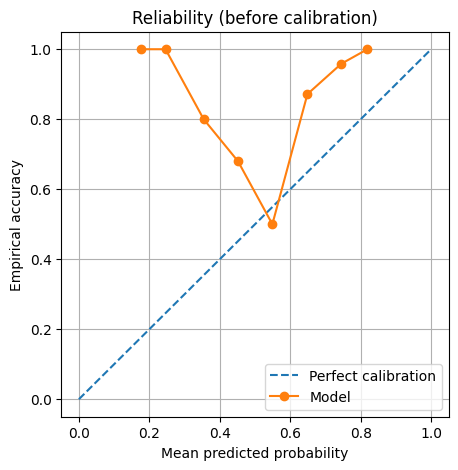

In [ ]:
probs_raw = torch.sigmoid(all_logits).detach().cpu().numpy()
labels_np = all_labels.detach().cpu().numpy()

ece_before = compute_ece(probs_raw, labels_np, n_bins=10)

from sklearn.metrics import brier_score_loss

brier_before = brier_score_loss(labels_np, probs_raw)

print(f"ECE before temperature scaling : {ece_before:.4f}")
print(f"Brier score before            : {brier_before:.4f}")

reliability_plot(probs_raw, labels_np, title="Reliability (before calibration)")


In [ ]:
import torch.nn as nn

# parameter is log_temp so T = exp(log_temp) > 0
log_temp = nn.Parameter(torch.zeros(1, device=device))   # T=1 initially
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.LBFGS([log_temp], lr=0.01, max_iter=50)

def _closure():
    optimizer.zero_grad()
    T = torch.exp(log_temp)
    loss = criterion(all_logits / T, all_labels)
    loss.backward()
    return loss

loss_before = criterion(all_logits, all_labels).item()
print(f"NLL before scaling: {loss_before:.4f}")

optimizer.step(_closure)

T_opt = torch.exp(log_temp).item()
loss_after = criterion(all_logits / torch.exp(log_temp), all_labels).item()

print(f"Optimal temperature T: {T_opt:.4f}")
print(f"NLL after scaling : {loss_after:.4f}")


NLL before scaling: 0.5117
Optimal temperature T: 0.9408
NLL after scaling : 0.5042


ECE after temperature scaling  : 0.2513
Brier score after             : 0.1621


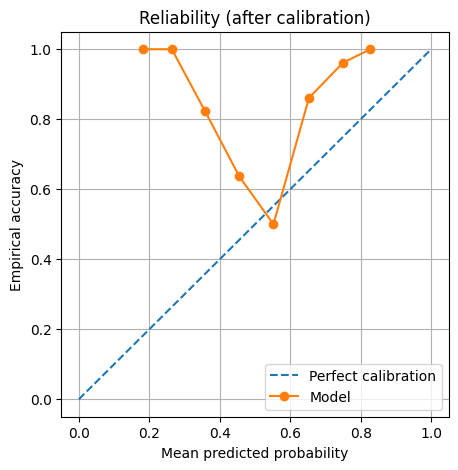

In [ ]:
# apply learned temperature
T = torch.exp(log_temp)
probs_cal = torch.sigmoid(all_logits / T).detach().cpu().numpy()

ece_after = compute_ece(probs_cal, labels_np, n_bins=10)
brier_after = brier_score_loss(labels_np, probs_cal)

print(f"ECE after temperature scaling  : {ece_after:.4f}")
print(f"Brier score after             : {brier_after:.4f}")

reliability_plot(probs_cal, labels_np, title="Reliability (after calibration)")


In [ ]:
def predict_one_mt_calibrated(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    tf = get_transforms(train=False)
    x = tf(img_rgb).unsqueeze(0).to(device)

    with torch.no_grad():
        logit, hb_pred = model_mt(x)
        logit = logit / torch.exp(log_temp)   # apply temperature
        prob_anemic = torch.sigmoid(logit)[0].item()
        hb_val = hb_pred[0].item()

    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()
    print(f"Calibrated Prob Anemic = {prob_anemic:.3f}")
    print(f"Predicted Hb          = {hb_val:.2f} g/dL")


In [ ]:
from torchvision.transforms import v2 as T


Testing on: /content/Anemic_Project/raw/Anemic/Image_285.png


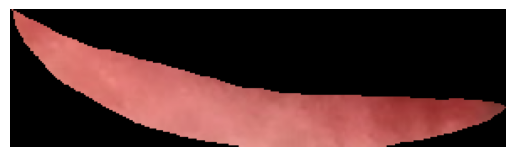

Calibrated Prob Anemic = 0.839
Predicted Hb          = 4.60 g/dL


In [ ]:
# for example, use a real image path from your dataset
sample_path = train_hb.iloc[0]["image_path"]   # or any other path you like
print("Testing on:", sample_path)

predict_one_mt_calibrated(sample_path)


Testing on: /content/Anemic_Project/raw/Anemic/Image_285.png


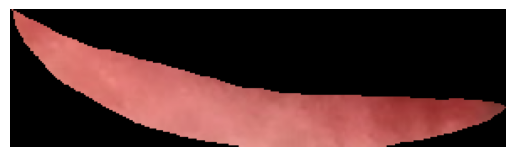

Calibrated Prob Anemic = 0.839
Predicted Hb          = 4.60 g/dL


In [ ]:
def predict_one_mt_calibrated(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    tf = get_transforms(train=False)
    x = tf(img_rgb).unsqueeze(0).to(device)

    with torch.no_grad():
        logit, hb_pred = model_mt(x)
        logit = logit / torch.exp(log_temp)   # apply temperature
        prob_anemic = torch.sigmoid(logit)[0].item()
        hb_val = hb_pred[0].item()

    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()
    print(f"Calibrated Prob Anemic = {prob_anemic:.3f}")
    print(f"Predicted Hb          = {hb_val:.2f} g/dL")


# 👇 actually call the function
sample_path = train_hb.iloc[0]["image_path"]   # or any known image path
print("Testing on:", sample_path)
predict_one_mt_calibrated(sample_path)


In [ ]:
model_mt.load_state_dict(torch.load("/content/Anemic_Project/multitask_model.pt", map_location=device))
model_mt.eval()


AnemiaMultiTask(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw

In [ ]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as T
import pandas as pd # Import pandas here as it's used in the dataset class
import os # Import os for path joining

def get_transforms(train=True):
    if train:
        return T.Compose([
            T.ToImage(),
            T.Resize((300, 300)),
            T.RandomHorizontalFlip(),
            T.ColorJitter(brightness=0.2, contrast=0.2),
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])
    else:
        return T.Compose([
            T.ToImage(),
            T.Resize((300, 300)),
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])

class AnemiaMultiTaskDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform

        # ensure no missing Hb
        self.df = self.df.dropna(subset=["HB_LEVEL"]).reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        y_class = torch.tensor(row["label"], dtype=torch.long)
        y_hb    = torch.tensor(row["HB_LEVEL"], dtype=torch.float32)

        return img, (y_class, y_hb)

# Ensure PROC_DIR is defined if not already in this scope
BASE_DIR = "/content/Anemic_Project"
PROC_DIR = os.path.join(BASE_DIR, "processed")

train_hb_csv = f"{PROC_DIR}/train_hb.csv"
val_hb_csv   = f"{PROC_DIR}/val_hb.csv"

train_ds_mt = AnemiaMultiTaskDataset(train_hb_csv, transform=get_transforms(train=True))
val_ds_mt   = AnemiaMultiTaskDataset(val_hb_csv,   transform=get_transforms(train=False))

train_loader_mt = DataLoader(train_ds_mt, batch_size=16, shuffle=True,  num_workers=2)
val_loader_mt   = DataLoader(val_ds_mt,   batch_size=16, shuffle=False, num_workers=2)

print("Train size:", len(train_ds_mt))
print("Val size:", len(val_ds_mt))

Train size: 568
Val size: 142


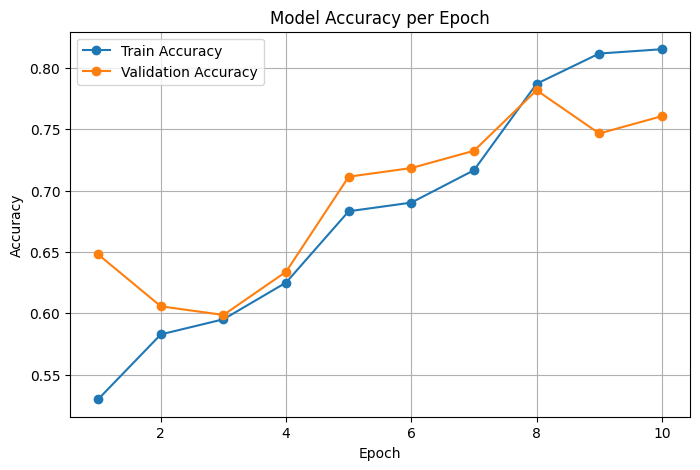

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc_list) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc_list, marker='o', label="Train Accuracy")
plt.plot(epochs, val_acc_list, marker='o', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, mean_absolute_error, mean_squared_error, brier_score_loss, roc_curve
import matplotlib.pyplot as plt

# ---- EVAL ON VALIDATION SET (FINAL METRICS) ----
model_mt.eval()

all_y_true = []
all_y_prob = []
all_y_pred = []
all_hb_true = []
all_hb_pred = []

with torch.no_grad():
    for imgs, (y_class, y_hb) in val_loader_mt:
        imgs  = imgs.to(device)
        y_cls = y_class.to(device)
        y_hb  = y_hb.to(device)

        logits, hb_out = model_mt(imgs)

        probs = torch.sigmoid(logits)              # [batch]
        preds = (probs >= 0.5).long()              # 0/1

        all_y_true.extend(y_cls.cpu().numpy())
        all_y_prob.extend(probs.cpu().numpy())
        all_y_pred.extend(preds.cpu().numpy())
        all_hb_true.extend(y_hb.cpu().numpy())
        all_hb_pred.extend(hb_out.cpu().numpy())

all_y_true = np.array(all_y_true)
all_y_prob = np.array(all_y_prob)
all_y_pred = np.array(all_y_pred)
all_hb_true = np.array(all_hb_true)
all_hb_pred = np.array(all_hb_pred)


Final Val AUC   : 0.879
Final Val F1    : 0.819
Final Val Acc   : 0.761
Final Brier     : 0.1681


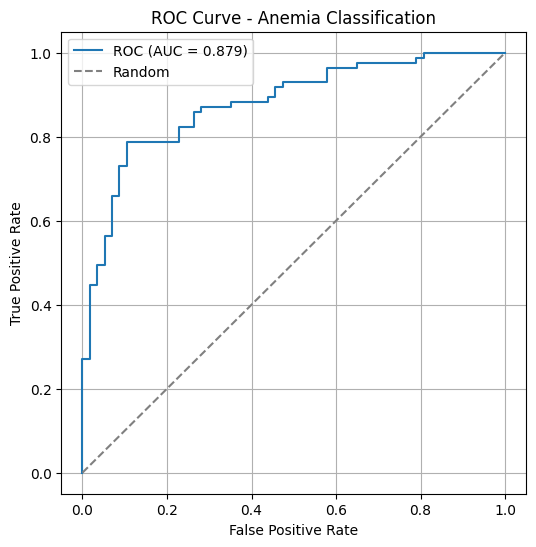

In [ ]:
# ---- CLASSIFICATION METRICS ----
auc  = roc_auc_score(all_y_true, all_y_prob)
f1   = f1_score(all_y_true, all_y_pred)
acc  = accuracy_score(all_y_true, all_y_pred)
brier = brier_score_loss(all_y_true, all_y_prob)

print(f"Final Val AUC   : {auc:.3f}")
print(f"Final Val F1    : {f1:.3f}")
print(f"Final Val Acc   : {acc:.3f}")
print(f"Final Brier     : {brier:.4f}")

# ---- ROC CURVE PLOT ----
fpr, tpr, thresholds = roc_curve(all_y_true, all_y_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], "--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Anemia Classification")
plt.legend()
plt.grid(True)
plt.show()


Final Hb MAE  : 1.723 g/dL
Final Hb RMSE : 2.214 g/dL


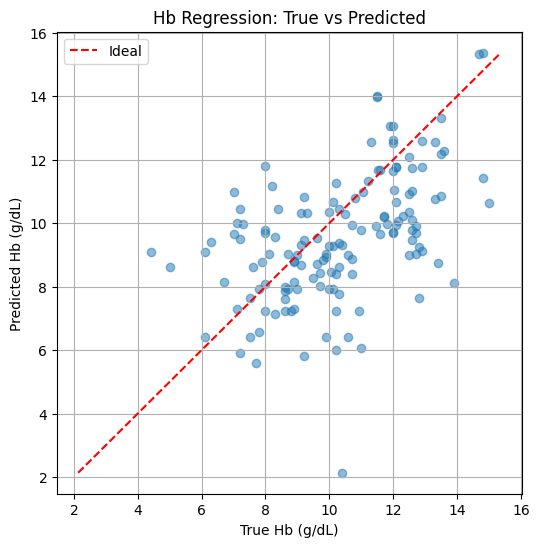

In [ ]:
# ---- REGRESSION METRICS (Hb) ----
hb_mae  = mean_absolute_error(all_hb_true, all_hb_pred)
hb_rmse = np.sqrt(mean_squared_error(all_hb_true, all_hb_pred))

print(f"Final Hb MAE  : {hb_mae:.3f} g/dL")
print(f"Final Hb RMSE : {hb_rmse:.3f} g/dL")

# Optional: scatter plot predicted vs true Hb
plt.figure(figsize=(6,6))
plt.scatter(all_hb_true, all_hb_pred, alpha=0.5)
min_hb = min(all_hb_true.min(), all_hb_pred.min())
max_hb = max(all_hb_true.max(), all_hb_pred.max())
plt.plot([min_hb, max_hb], [min_hb, max_hb], "r--", label="Ideal")
plt.xlabel("True Hb (g/dL)")
plt.ylabel("Predicted Hb (g/dL)")
plt.title("Hb Regression: True vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

all_y_true = np.array(all_y_true).astype(int)      # shape [N]
all_y_prob = np.array(all_y_prob).astype(float)    # shape [N]

print("Shapes:", all_y_true.shape, all_y_prob.shape)
print("Prob range:", all_y_prob.min(), all_y_prob.max())
print("Unique labels:", np.unique(all_y_true))


Shapes: (142,) (142,)
Prob range: 0.1852971613407135 0.8368790149688721
Unique labels: [0 1]


Shapes: (142,) (142,)
Prob range: 0.1852971613407135 0.8368790149688721
Unique labels: [0 1]
ECE (uncalibrated): 0.2585


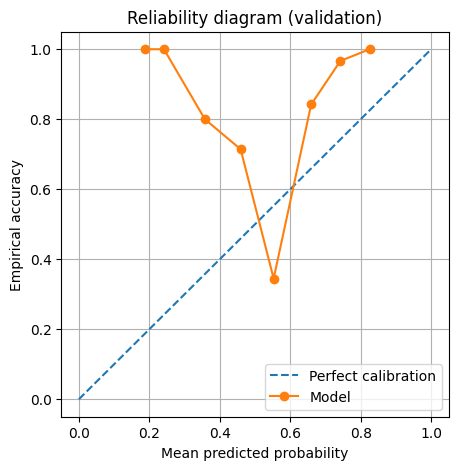

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Ensure arrays are correct
all_y_true = np.array(all_y_true).astype(int).reshape(-1)
all_y_prob = np.array(all_y_prob).astype(float).reshape(-1)

print("Shapes:", all_y_true.shape, all_y_prob.shape)
print("Prob range:", all_y_prob.min(), all_y_prob.max())
print("Unique labels:", np.unique(all_y_true))

# 2. ECE + reliability functions
def compute_ece(probs, labels, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    indices = np.digitize(probs, bins) - 1

    ece = 0.0
    N = len(probs)

    for b in range(n_bins):
        mask = indices == b
        if np.sum(mask) == 0:
            continue
        bin_probs  = probs[mask]
        bin_labels = labels[mask]
        avg_conf = bin_probs.mean()
        avg_acc  = (bin_labels == (bin_probs >= 0.5)).mean()
        ece += (np.sum(mask) / N) * abs(avg_conf - avg_acc)
    return ece


def reliability_plot(probs, labels, n_bins=10, title="Reliability diagram"):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    indices = np.digitize(probs, bins) - 1

    bin_acc = []
    bin_conf = []
    for b in range(n_bins):
        mask = indices == b
        if np.sum(mask) == 0:
            continue
        bin_probs  = probs[mask]
        bin_labels = labels[mask]
        avg_conf = bin_probs.mean()
        avg_acc  = (bin_labels == (bin_probs >= 0.5)).mean()

        bin_conf.append(avg_conf)
        bin_acc.append(avg_acc)

    plt.figure(figsize=(5,5))
    plt.plot([0,1], [0,1], "--", label="Perfect calibration")
    plt.plot(bin_conf, bin_acc, marker="o", label="Model")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Empirical accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# 3. Compute and plot
ece = compute_ece(all_y_prob, all_y_true, n_bins=10)
print(f"ECE (uncalibrated): {ece:.4f}")

reliability_plot(all_y_prob, all_y_true, n_bins=10,
                 title="Reliability diagram (validation)")


In [ ]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    brier_score_loss
)

# make sure arrays are clean
all_y_true = np.array(all_y_true).astype(int).reshape(-1)
all_y_pred = np.array(all_y_pred).astype(int).reshape(-1)
all_y_prob = np.array(all_y_prob).astype(float).reshape(-1)

all_hb_true = np.array(all_hb_true).astype(float).reshape(-1)
all_hb_pred = np.array(all_hb_pred).astype(float).reshape(-1)

# ---- classification metrics ----
auc = roc_auc_score(all_y_true, all_y_prob)
f1  = f1_score(all_y_true, all_y_pred)
acc = accuracy_score(all_y_true, all_y_pred)

# ---- regression metrics ----
mae  = mean_absolute_error(all_hb_true, all_hb_pred)
rmse = mean_squared_error(all_hb_true, all_hb_pred)

# ---- ECE ----
def compute_ece(probs, labels, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    indices = np.digitize(probs, bins) - 1

    ece = 0.0
    N = len(probs)

    for b in range(n_bins):
        mask = indices == b
        if np.sum(mask) == 0:
            continue
        bin_probs  = probs[mask]
        bin_labels = labels[mask]
        avg_conf = bin_probs.mean()
        avg_acc  = (bin_labels == (bin_probs >= 0.5)).mean()
        ece += (np.sum(mask) / N) * abs(avg_conf - avg_acc)
    return ece

ece = compute_ece(all_y_prob, all_y_true, n_bins=10)

# ---- print all results ----
print("=== FINAL VALIDATION METRICS ===")
print(f"ROC-AUC : {auc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"MAE     : {mae:.4f} g/dL")
print(f"RMSE    : {rmse:.4f} g/dL")
print(f"ECE     : {ece:.4f}")


=== FINAL VALIDATION METRICS ===
ROC-AUC : 0.8795
F1-score: 0.8191
Accuracy: 0.7606
MAE     : 1.7234 g/dL
RMSE    : 4.9011 g/dL
ECE     : 0.2585


In [ ]:
!zip -r /content/anemia_project_models.zip /content/Anemic_Project
from google.colab import files
files.download("/content/anemia_project_models.zip")


  adding: content/Anemic_Project/ (stored 0%)
  adding: content/Anemic_Project/multitask_model.pt (deflated 8%)
  adding: content/Anemic_Project/processed/ (stored 0%)
  adding: content/Anemic_Project/processed/val_hb.csv (deflated 86%)
  adding: content/Anemic_Project/processed/train_hb.csv (deflated 88%)
  adding: content/Anemic_Project/processed/val.csv (deflated 92%)
  adding: content/Anemic_Project/processed/train.csv (deflated 93%)
  adding: content/Anemic_Project/best_classifier.pt (deflated 8%)
  adding: content/Anemic_Project/raw/ (stored 0%)
  adding: content/Anemic_Project/raw/Non-anemic/ (stored 0%)
  adding: content/Anemic_Project/raw/Non-anemic/Image_117.png (stored 0%)
  adding: content/Anemic_Project/raw/Non-anemic/Image_373.png (deflated 0%)
  adding: content/Anemic_Project/raw/Non-anemic/Image_319.png (stored 0%)
  adding: content/Anemic_Project/raw/Non-anemic/Image_027.png (stored 0%)
  adding: content/Anemic_Project/raw/Non-anemic/Image_353.png (stored 0%)
  adding:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install onnx
!pip install onnxscript

import torch
import os

# Assuming model_mt and device are already defined in the notebook
# Load the trained PyTorch model
model_mt = AnemiaMultiTask().to(device)
model_mt.load_state_dict(torch.load("/content/Anemic_Project/multitask_model.pt", map_location=device))
model_mt.eval() # Set the model to evaluation mode

# Create a dummy input tensor with the expected shape
# Input images are resized to (300, 300) with 3 channels.
# Batch size is typically 1 for ONNX export unless specified otherwise.
dummy_input = torch.randn(1, 3, 300, 300).to(device)

onnx_file_path = os.path.join("/content/Anemic_Project", "multitask_model.onnx")

# --- ONNX Model Parameters ---
# Input:
#   Name: 'input'
#   Shape: (batch_size, 3, 300, 300)
#          - batch_size: dynamic
#          - 3: RGB channels
#          - 300, 300: Height and width of the image
#   Data Type: float32
#   Preprocessing: Images should be resized to 300x300 and normalized with
#                  mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
# Outputs:
#   1. 'classification_output': Logits for binary classification (anemic/non-anemic), shape (batch_size,)
#   2. 'regression_output': Predicted Hb level (regression), shape (batch_size,)
# -----------------------------
torch.onnx.export(model_mt,               # model being exported
                     dummy_input,          # model input (or a tuple for multiple inputs)
                     onnx_file_path,       # where to save the ONNX model
                     export_params=True,   # store the trained parameter weights inside the model file
                     opset_version=11,     # the ONNX version to export the model to
                     do_constant_folding=True, # whether to execute constant folding for optimization
                     input_names = ['input'],   # the name to assign to the input node
                     output_names = ['classification_output', 'regression_output'], # the names to assign to the output nodes
                     dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                   'classification_output' : {0 : 'batch_size'},
                                   'regression_output' : {0 : 'batch_size'}})

print(f"Model successfully exported to ONNX at: {onnx_file_path}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 6.8 MB/s eta 0:00:00


/tmp/ipython-input-1686741274.py:34: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(model_mt,               # model being exported
W1122 05:05:38.819000 315 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `AnemiaMultiTask([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `AnemiaMultiTask([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Translate the graph into ONNX... ✅
Applied 98 of general pattern rewrite rules.
Model successfully exported to ONNX at: /content/Anemic_Project/multitask_model.onnx
